<a href="https://play-ashburn.neurodesk.org/v2/gh/neurodesk/example-notebooks/main?labpath=/home/jovyan/examples/example-notebooks/books/structural_imaging/nipype_module_example.ipynb" target="_parent"><img src="https://img.shields.io/badge/launch-binder-579aca.svg?logo=" alt="Open In Binder"/>  </a>
<a href="https://colab.research.google.com/github/NeuroDesk/example-notebooks/blob/main/books/structural_imaging/nipype_module_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>   </a>

## Basic Nipype Example

Author: Steffen Bollmann

## Setup Neurodesk

In [1]:
import os
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  os.environ["LD_PRELOAD"] = "";
  os.environ["APPTAINER_BINDPATH"] = "/content,/tmp,/cvmfs"
  os.environ["MPLCONFIGDIR"] = "/content/matplotlib-mpldir"
  os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

  !curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
  !chmod +x googlecolab_setup.sh
  !./googlecolab_setup.sh

  os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))

  from google.colab import output
  output.enable_custom_widget_manager()
  !pip install ipyniivue

In [2]:
# Output CPU information:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: AuthenticAMD
model name	: AMD EPYC 7742 64-Core Processor


# Demonstrating the module system in Python and Nipype

In [3]:
# we can use lmod to load fsl in a specific version
import lmod
await lmod.load('fsl/6.0.4')
await lmod.list()

['fsl/6.0.4']

In [4]:
from nipype.interfaces.fsl.base import Info
print(Info.version())
# if the FSL version is changed using lmod above, the kernel of the notebook needs to be restarted!

6.0.4:ddd0a010


In [5]:
!bet


Usage:    bet <input> <output> [options]

Main bet2 options:
  -o          generate brain surface outline overlaid onto original image
  -m          generate binary brain mask
  -s          generate approximate skull image
  -n          don't generate segmented brain image output
  -f <f>      fractional intensity threshold (0->1); default=0.5; smaller values give larger brain outline estimates
  -g <g>      vertical gradient in fractional intensity threshold (-1->1); default=0; positive values give larger brain outline at bottom, smaller at top
  -r <r>      head radius (mm not voxels); initial surface sphere is set to half of this
  -c <x y z>  centre-of-gravity (voxels not mm) of initial mesh surface.
  -t          apply thresholding to segmented brain image and mask
  -e          generates brain surface as mesh in .vtk format

Variations on default bet2 functionality (mutually exclusive options):
  (default)   just run bet2
  -R          robust brain centre estimation (iterates BE

## Load afni as well

In [6]:
await lmod.load('afni/22.3.06')
await lmod.list()

['fsl/6.0.4', 'afni/22.3.06']

## download test data

In [7]:
![ -f ./sub-01_ses-01_7T_T1w_defaced.nii  ] && echo "$FILE exist." || wget https://api.opendata.ocs.oraclecloud.com/data/tomcat/TOMCAT_DIB/sub-01/ses-01_7T/anat/sub-01_ses-01_7T_T1w_defaced.nii.gz -O ./sub-01_ses-01_7T_T1w_defaced.nii.gz 
![ -f ./sub-01_ses-01_7T_T1w_defaced.nii  ] && echo "$FILE exist." || gunzip ./sub-01_ses-01_7T_T1w_defaced.nii.gz 

--2023-06-15 03:21:54--  https://objectstorage.us-ashburn-1.oraclecloud.com/n/idrvm4tkz2a8/b/TOMCAT/o/TOMCAT_DIB/sub-01/ses-01_7T/anat/sub-01_ses-01_7T_T1w_defaced.nii.gz
Resolving objectstorage.us-ashburn-1.oraclecloud.com (objectstorage.us-ashburn-1.oraclecloud.com)... 134.70.32.1, 134.70.24.1, 134.70.28.1
Connecting to objectstorage.us-ashburn-1.oraclecloud.com (objectstorage.us-ashburn-1.oraclecloud.com)|134.70.32.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72682635 (69M) [application/octet-stream]
Saving to: ‘./sub-01_ses-01_7T_T1w_defaced.nii.gz’

./sub-01_ses-01_7T_ 100%[===================>]  69.32M  16.4MB/s    in 4.2s    

2023-06-15 03:21:59 (16.4 MB/s) - ‘./sub-01_ses-01_7T_T1w_defaced.nii.gz’ saved [72682635/72682635]



In [8]:
!ls 

bids			     qsm
dicoms-sorted		     qsmxt_example.ipynb
dicoms-unsorted		     sct_example_data
nipype_module_example.ipynb  sct_toolbox_example.ipynb
qc			     sub-01_ses-01_7T_T1w_defaced.nii


## run nipype pipeline

In [9]:
%%capture
!pip install nipype

In [10]:
from nipype.interfaces import fsl
from nipype.interfaces import afni

btr = fsl.BET()
btr.inputs.in_file = './sub-01_ses-01_7T_T1w_defaced.nii'
btr.inputs.frac = 0.4
btr.inputs.out_file = './sub-01_ses-01_7T_T1w_defaced_brain.nii'
res = btr.run() 

edge3 = afni.Edge3()
edge3.inputs.in_file = './sub-01_ses-01_7T_T1w_defaced.nii'
edge3.inputs.out_file = './sub-01_ses-01_7T_T1w_defaced_edges.nii'
edge3.inputs.datum = 'byte'
res = edge3.run()

230615-03:22:04,658 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
230615-03:22:11,951 nipype.interface INFO:
	 stderr 2023-06-15T03:22:11.951122:++ 3dedge3: AFNI version=AFNI_22.3.06 (Nov 15 2022) [64-bit]
230615-03:22:11,952 nipype.interface INFO:
	 stderr 2023-06-15T03:22:11.952850:** AFNI converts NIFTI_datatype=4 (INT16) in file /home/jovyan/example-notebooks/structural_imaging/sub-01_ses-01_7T_T1w_defaced.nii to FLOAT32
230615-03:22:11,953 nipype.interface INFO:
	 stderr 2023-06-15T03:22:11.952850:     Warnings of this type will be muted for this session.
230615-03:22:11,953 nipype.interface INFO:
	 stderr 2023-06-15T03:22:11.952850:     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
230615-03:22:11,954 nipype.interface INFO:
	 stderr 2023-06-15T03:22:11.954253:*+ WARNING:   If you are performing spatial transformations on an oblique dset,
230615-03:22:11,954 nipype.interface INFO:
	 stderr 2023-06-15T03:22

In [11]:
!ls

bids			     qsmxt_example.ipynb
dicoms-sorted		     sct_example_data
dicoms-unsorted		     sct_toolbox_example.ipynb
nipype_module_example.ipynb  sub-01_ses-01_7T_T1w_defaced.nii
qc			     sub-01_ses-01_7T_T1w_defaced_brain.nii.gz
qsm			     sub-01_ses-01_7T_T1w_defaced_edges.nii


In [12]:
# View 3D data
import matplotlib.pyplot as plt

def view_slices_3d(image_3d, slice_nbr, vmin, vmax, title=''):
#   print('Matrix size: {}'.format(image_3d.shape))
  fig = plt.figure(figsize=(15, 4))
  plt.suptitle(title, fontsize=10)

  plt.subplot(131)
  plt.imshow(np.take(image_3d, slice_nbr, 2), vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Axial');

  plt.subplot(132)
  image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 1),90)
  plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Coronal');

  plt.subplot(133)
  image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 0),90)
  plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Sagittal');
  cbar=plt.colorbar()

def get_figure():
    """
    Returns figure and axis objects to plot on. 
    """
    fig, ax = plt.subplots(1)
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

In [13]:
import nibabel as nib
from matplotlib import transforms
from scipy import ndimage
import numpy as np

# load data
brain_full = nib.load('./sub-01_ses-01_7T_T1w_defaced.nii').get_fdata()
brain = nib.load('./sub-01_ses-01_7T_T1w_defaced_brain.nii.gz').get_fdata()
edges = nib.load('./sub-01_ses-01_7T_T1w_defaced_edges.nii').get_fdata()

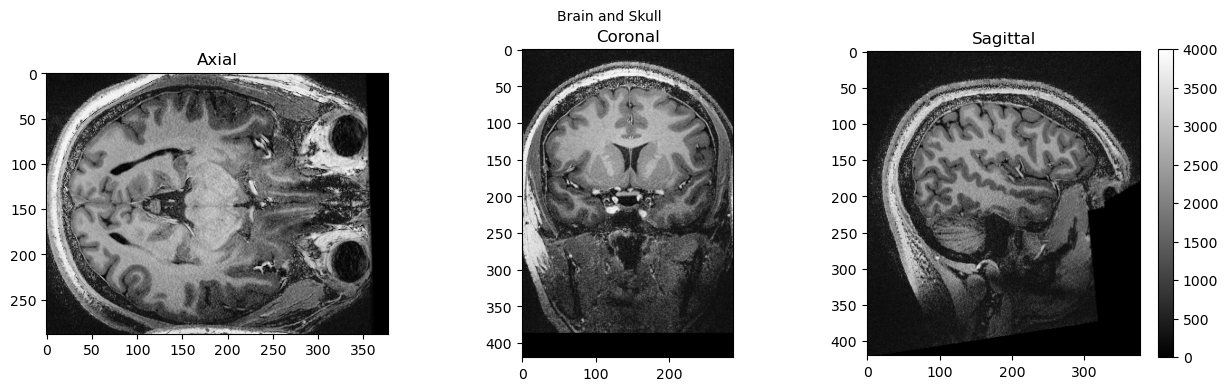

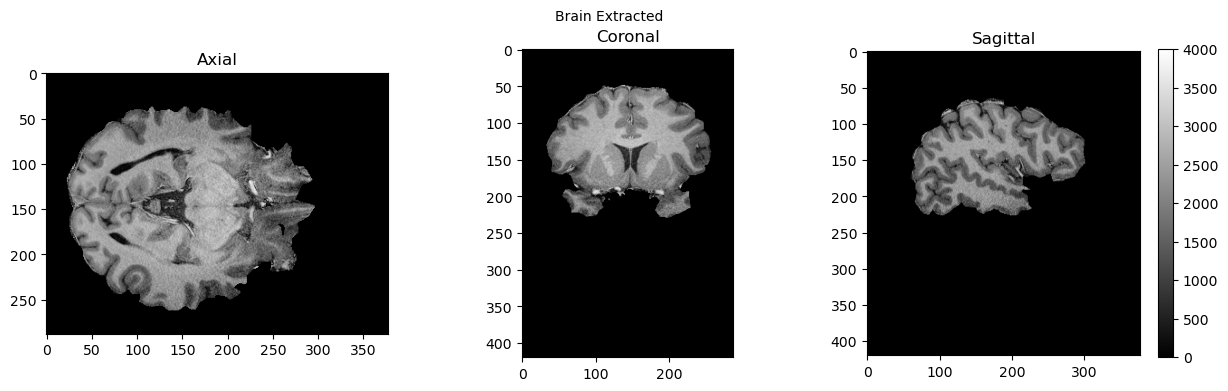

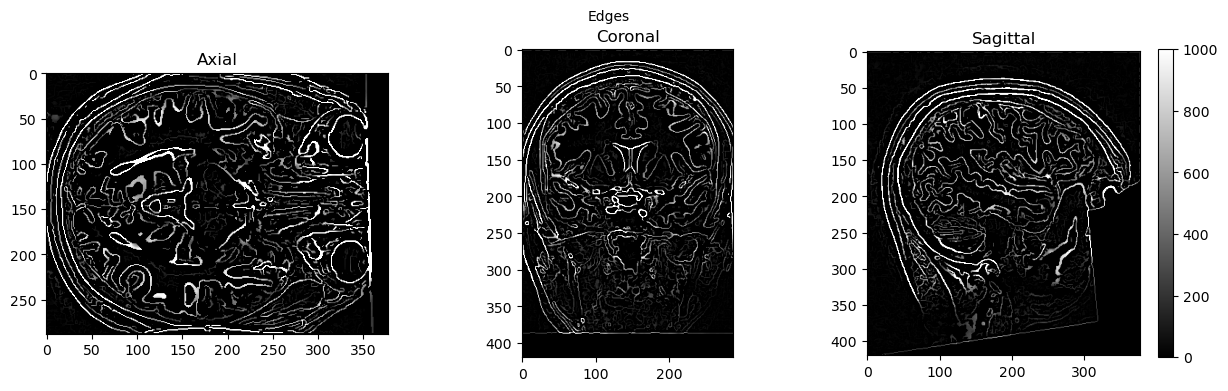

In [14]:
view_slices_3d(brain_full, slice_nbr=230, vmin=0, vmax=4000, title='Brain and Skull')
view_slices_3d(brain, slice_nbr=230, vmin=0, vmax=4000, title='Brain Extracted')
view_slices_3d(edges, slice_nbr=230, vmin=0, vmax=1000, title='Edges')

In [19]:
import ipyniivue
nv = ipyniivue.Niivue(crosshair_color=[0,1,0,1])
nv.add_volume('./sub-01_ses-01_7T_T1w_defaced_brain.nii.gz')
nv

ipyniivue.Niivue(back_color=[0.0, 0.0, 0.0, 1.0], clip_plane_color=[1.0, 1.0, 1.0, 0.5], crosshair_color=[0.0,…